#  用Tensorflow建立的第一个神经网络

我们将使用一个自行车租赁数据库来训练网络，并预测出租用数量

In [1]:
# 让输出的图形直接在Notebook中显示
%matplotlib inline

# better for looking
%config InlineBackend.figure_format = 'retina' 

#导入需要使用的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


# 读入数据文件，并对数据进行预处理

In [10]:
#读取数据到内存中，rides为一个dataframe对象
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

#看看数据长什么样子
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## 对于类型变量的处理

有很多变量都属于类型变量，例如season=1,2,3,4，分四季。我们不能将season变量直接输入到神经网络，这是因为season数值越高并不表示相应的信号强度越大。我们的解决方案是将类型变量用一个“一位热码“（one-hot）来编码，也就是：

$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有n个不同取值，那么我们的“一位热码“所对应的向量长度就为n

In [11]:
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

## 对于数值类型变量进行标准化
由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系，为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。比如，对于温度temp这个变量来说，它在整个数据库取值的平均着为mean(temp), 方差为std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

In [12]:
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
# 我们将每一个变量的均值和方差都存储到scaled_features变量中。

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

## 将数据集进行分割

In [13]:
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# 将我们的数据列分为特征列和目标列

#目标列
target_fields = ['cnt','casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 再把所有的训练数据分为测试集和校验集
# 其中测试集为训练数据随机抽样80％而构成，剩下的作为校验集
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

# TensorFlow构建神经网络，训练

该网络有54个输入层节点（对应54个输入变量）、hidden_nodes个隐含层节点，以及1个输出层节点
从输入到隐含层的权重矩阵为$w_h$（56行，hidden_nodes列），从隐含层到输出层的权重矩阵为$w_o$（10行，1列）
如果输入数据为向量（或矩阵）$x$（1行或batch行，batch为数据撮的大小，56列），则从输入到输出的前馈过程计算公式为：

$
y=\sigma(x\cdot w_h)\cdot w_o
$

其中$\sigma(x)=\frac{1}{1+\exp(-x)}$, $\cdot$为矩阵的乘法。

为了调整权重：$w_h$和$w_o$，我们只需要按照梯度下降法，不断最小化损失函数：

$
E=\sum_{i=1}^{N}(y_i - y(x_i))^2
$

其中$N$为一个撮中的样本总数，$x_i$为第i个样本的输入向量，$y(x_i)$为由输入$x_i$得到的该变量的输出值。

In [14]:
#随机化初始权重的过程
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

#神经网络正向前馈的计算过程
def model(X, w_h, w_o):
    h = tf.nn.sigmoid(tf.matmul(X, w_h)) # 隐含层的计算过程
    return tf.matmul(h, w_o) # 输出层的计算

#定义输入变量和输出变量，这两个变量为虚拟变量，会因数据而不同
X = tf.placeholder("float", [None, 56])
Y = tf.placeholder("float", [None, 1])

#定义超参数
epochs = 5000  #训练的总轮数
learning_rate = 0.01  #学习率，该数值越大，权重调整的幅度越大，越不稳定
hidden_nodes = 10 #隐含层节点的数量
output_nodes = 1 #输出层节点的数量

w_h = init_weights([56, hidden_nodes]) # 初始化神经网络的权重矩阵为随机矩阵
w_o = init_weights([hidden_nodes, output_nodes])

py_x = model(X, w_h, w_o) #模型前馈的计算公式

cost = tf.reduce_mean(tf.square(Y - py_x)) # 待优化的目标函数值
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) # 使用梯度下降法进行优化
predict_op = py_x

In [16]:
#训练网络
# 在TensorFlow中加载定义好的运算图
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 计算误差时候用的辅助变量
trains = train_features.values
targets = train_targets['cnt']
targets = np.reshape(targets, [len(targets),1])
losses = []
vlosses = []

# 神经网络训练循环
for i in range(epochs):
    # 每128个样本点被划分为一个撮
    for start, end in zip(range(0, len(train_features), 128), range(128, len(train_features)+1, 128)):
        sess.run(train_op, feed_dict={X: trains[start:end], Y: targets[start:end]})
    
    # 每隔10步输出一下损失值（cost）
    if i%10==0:
        # 在所有训练集上跑出来的预测值和损失函数
        predict = sess.run(predict_op, feed_dict={X: trains})
        err = sess.run(cost, feed_dict={X: trains, Y: targets})
        # 在测试集上跑出来的预测值和损失函数
        validation = sess.run(predict_op, feed_dict={X: val_features})
        verr = sess.run(cost, feed_dict={X: val_features, Y: np.reshape(val_targets['cnt'],[len(val_targets['cnt']), 1])})
        losses.append(err)
        vlosses.append(verr)
        print(i, err,verr)

(0, 1.0051836, 1.018839)
(10, 0.94959372, 0.96008378)
(20, 0.64258939, 0.63761103)
(30, 0.50475121, 0.50488615)
(40, 0.3898308, 0.39808404)
(50, 0.33250922, 0.34688568)
(60, 0.31359875, 0.3311967)
(70, 0.30499101, 0.323917)
(80, 0.29785696, 0.31705141)
(90, 0.29122159, 0.31022468)
(100, 0.28582066, 0.30455077)
(110, 0.28191674, 0.30043542)
(120, 0.27918193, 0.29755995)
(130, 0.27716786, 0.29545149)
(140, 0.27553871, 0.29375416)
(150, 0.27409396, 0.29225585)
(160, 0.27272567, 0.29084337)
(170, 0.27138045, 0.28946111)
(180, 0.27003443, 0.28808445)
(190, 0.26867858, 0.28670529)
(200, 0.26731384, 0.28532439)
(210, 0.26594403, 0.28394678)
(220, 0.26457554, 0.28257969)
(230, 0.26321438, 0.28123006)
(240, 0.26186615, 0.27990431)
(250, 0.26053467, 0.27860662)
(260, 0.25922221, 0.27733988)
(270, 0.25793064, 0.27610448)
(280, 0.25665981, 0.27489966)
(290, 0.25540861, 0.27372327)
(300, 0.25417396, 0.27257133)
(310, 0.25295267, 0.27143908)
(320, 0.25173891, 0.27032006)
(330, 0.25052539, 0.26920584

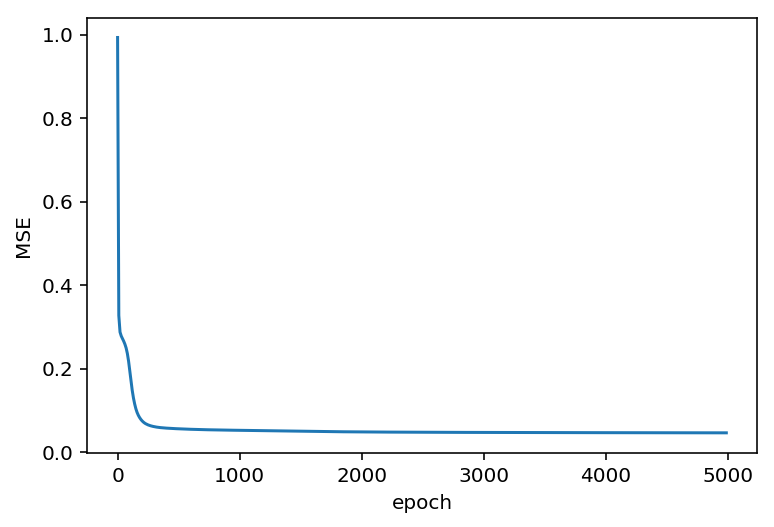

In [31]:
# 打印输出损失值
plt.plot(np.arange(500)*10,losses)
plt.hold
#plt.plot(vlosses)
plt.xlabel('epoch')
plt.ylabel('MSE')

## 预测及其结果

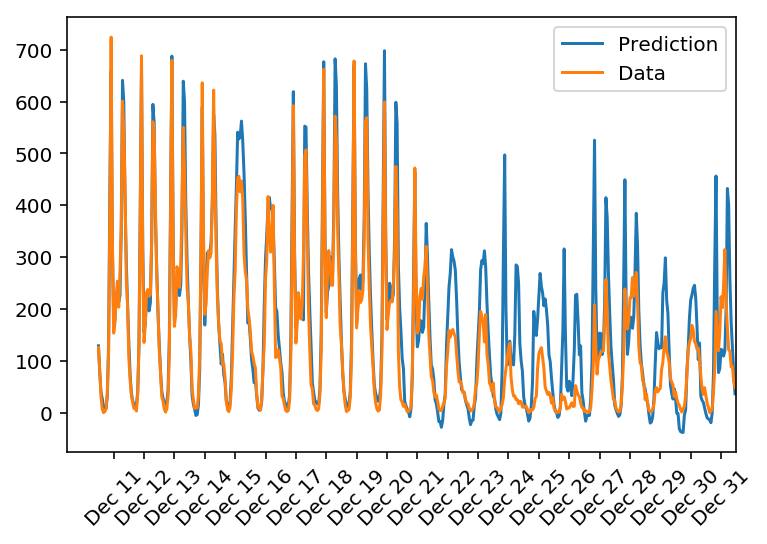

In [32]:
# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
targets = test_targets['cnt']
targets = np.reshape(targets, [len(targets),1])
predict = sess.run(predict_op, feed_dict={X:test_features.values, Y:targets})
fig, ax = plt.subplots()

mean, std = scaled_features['cnt']
ax.plot(predict*std + mean, label='Prediction')
ax.plot(targets*std + mean, label='Data')
ax.set_xlim(right=len(predict))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 通过实验分析神经网络

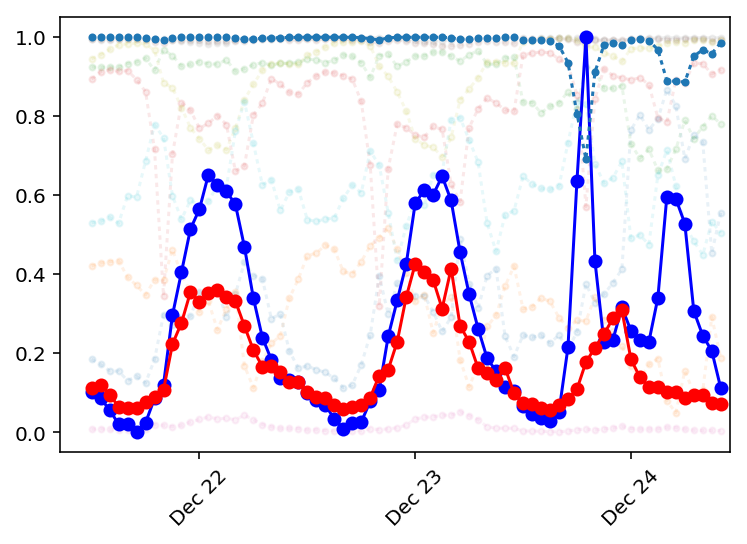

In [46]:
# 选出三天预测不准的日期：Dec 22，23，24
# 将这三天的数据聚集到一起，存入subset和subtargets中
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'
bools = [any(tup) for tup in zip(bool1,bool2,bool3) ]
subset = test_features.ix[rides[bools].index]

subtargets = test_targets.ix[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = np.reshape(subtargets, [len(subtargets),1])


# 将这几天的数据输入到神经网络中，读取出隐含层神经元的激活数值，存入results中
results = sess.run(tf.nn.sigmoid(tf.matmul(X, w_h)), feed_dict={X: subset.values})

# 这些数据对应的预测值（输出层）
predict = sess.run(predict_op, feed_dict={X:subset.values, Y:subtargets})

# 将所有的神经元激活水平画在同一张图上，蓝色的是模型预测的数值
fig, ax = plt.subplots()
ax.plot(results[:,:],'.:',alpha=0.1)
ax.plot((predict - min(predict)) / (max(predict) - min(predict)),'bo-',label='Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)),'ro-',label='Real')
ax.plot(results[:,4],'.:',alpha=1,label='Neuro 4')

ax.set_xlim(right=len(predict))
#ax.legend()

dates = pd.to_datetime(rides.ix[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

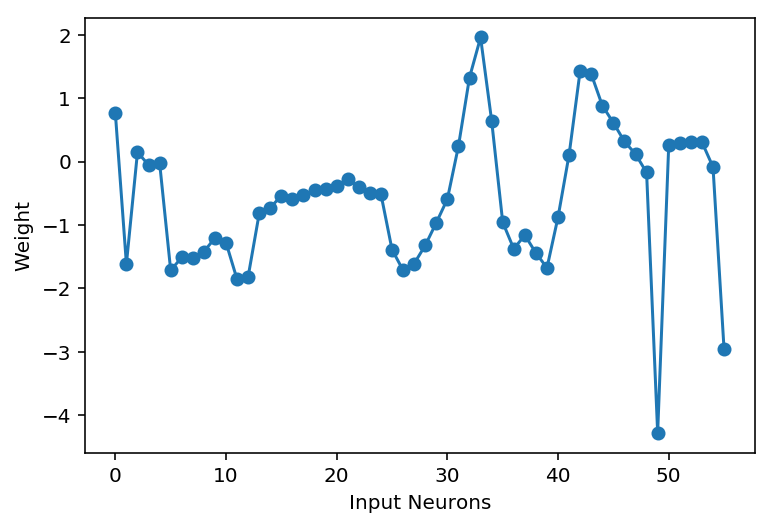

In [246]:
# 找到了与峰值响应的神经元，把它到输入层的权重输出出来
plt.plot(sess.run(w_h)[:,3],'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

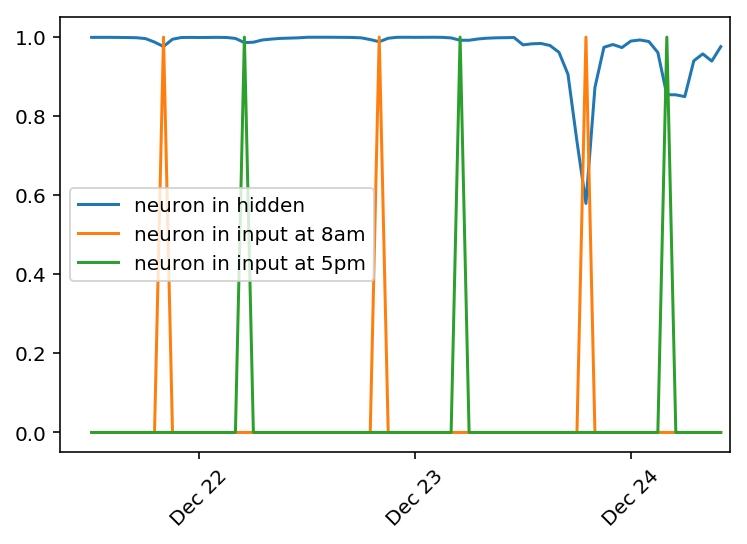

In [211]:
# 显示在不同日期，指定的第5个隐含层神经元细胞的激活值，以及输入层响应
fig, ax = plt.subplots()
ax.plot(results[:,4],label='neuron in hidden')
ax.plot(subset.values[:,33],label='neuron in input at 8am')
ax.plot(subset.values[:,42],label='neuron in input at 5pm')
ax.set_xlim(right=len(predict))
ax.legend()

dates = pd.to_datetime(rides.ix[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)


## 自定义神经网络算法

自定义一个具有一层隐含层的神经网络类

In [18]:
# 定义神经网络类
def sigmoidfun(x):
    return 1 / ( 1 + np.exp(- x))
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # 设定每一层神经元的个数.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # 用正态分布初始化权重
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.input_nodes))
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.output_nodes, self.hidden_nodes))
        
        self.learning_rate = learning_rate
        
        #### 设定激活函数
        self.activation_function = sigmoidfun
    
    def train(self, inputs_list, targets_list):
        # 将输入的数据（列表）转化为array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #计算隐含层的输入和输出
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs ) 
        hidden_outputs = self.activation_function(hidden_inputs)  
        
        #输出层的输入和输出，注意输出层没有sigmoid函数，相当于s(x)=x
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = final_inputs
        
        #### 这里开始反向传播 ###
        
        # 计算误差向量
        output_errors = (targets - final_outputs) 
        
        # 反向传播误差
        
        # 传入到隐含层的反向传播误差
        hidden_errors = np.dot (self.weights_hidden_to_output.T, output_errors) *\
                                hidden_outputs * (1 - hidden_outputs) 
        
        
        # 更新权重
        
        self.weights_hidden_to_output += self.learning_rate * output_errors * hidden_outputs.T  # 更新隐含－输出层的权重
        self.weights_input_to_hidden += self.learning_rate * hidden_errors * inputs.T # 更新输入－隐含层权重
        
        
    def run(self, inputs_list):
        # 运行前向神经网络
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### 前向传播 ####
        # 隐含层
        hidden_inputs = np.dot(self.weights_input_to_hidden , inputs)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # 输出层
        final_inputs = np.dot(self.weights_hidden_to_output , hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [17]:
### 设置超参数 ###
epochs = 5000
learning_rate = 0.01
hidden_nodes = 10
output_nodes = 1

## 定义神经网络 ##
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # 将数据每128个座位一撮，进行训练
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    if e%(epochs/10) == 0:
        # 计算误差
        train_loss = MSE(network.run(train_features) , train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features) , val_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Training loss: {:.4f}'.format(train_loss))
        print('Validation loss: {:.4f}'.format(val_loss))

Training loss: 1.0728
Validation loss: 1.0543
Training loss: 0.2227
Validation loss: 0.2243
Training loss: 0.1120
Validation loss: 0.1117
Training loss: 0.0794
Validation loss: 0.0792
Training loss: 0.0698
Validation loss: 0.0704
Training loss: 0.0658
Validation loss: 0.0687
Training loss: 0.0624
Validation loss: 0.0650
Training loss: 0.0626
Validation loss: 0.0638
Training loss: 0.0610
Validation loss: 0.0628
Training loss: 0.0597
Validation loss: 0.0617
